## Extract and Remove Value/Unit from catalog_content
This cell extracts the Value and Unit from the end of `catalog_content`, creates two new columns, and then strips these details from the original text.

# Import Libraries and Create Directories

In [ ]:
# Install PyTorch if not already installed
# paste this in terminal:
# pip3 install torch torchvision --index-url https://download.pytorch.org/whl/cu126
# !pip install scikit-learn

   ---------------------------------------- 0.0/8.9 MB ? eta -:--:--
   --------- ------------------------------ 2.1/8.9 MB 9.8 MB/s eta 0:00:01
   ---------------------- ----------------- 5.0/8.9 MB 12.1 MB/s eta 0:00:01
   ---------------------------------- ----- 7.6/8.9 MB 12.1 MB/s eta 0:00:01
   ---------------------------------------- 8.9/8.9 MB 12.0 MB/s  0:00:00
   ---------------------------------------- 0.0/38.7 MB ? eta -:--:--
   --- ------------------------------------ 3.1/38.7 MB 15.4 MB/s eta 0:00:03
   ------ --------------------------------- 6.6/38.7 MB 15.5 MB/s eta 0:00:03
   ---------- ----------------------------- 9.7/38.7 MB 15.9 MB/s eta 0:00:02
   ------------ --------------------------- 12.1/38.7 MB 15.4 MB/s eta 0:00:02
   ------------ --------------------------- 12.1/38.7 MB 15.4 MB/s eta 0:00:02
   ------------ --------------------------- 12.6/38.7 MB 10.0 MB/s eta 0:00:03
   ---------------- ----------------------- 16.0/38.7 MB 10.7 MB/s eta 0:00:03
   ----

In [31]:
# !pip install pandas numpy matplotlib jupyterlab ipywidgets

In [32]:
import os
import pandas as pd
import numpy as np
from IPython import display
from urllib.parse import urlparse, unquote
import re
import torch
from pathlib import Path
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', None)

In [33]:
# projects_dir_path = os.path.join(os.getcwd(), "projects")
# # os.makedirs(projects_dir_path, exist_ok=True)
# price_predict_project_path = os.path.join(projects_dir_path, "price_predict")
# os.makedirs(price_predict_project_path, exist_ok=True)
# os.chdir(price_predict_project_path)

move the csv files into the 'dataset' directory after creating it

In [34]:
# put your own directory path where the dataset is located
os.chdir(r'C:\Users\alvin\Desktop\projects\price_predict\dataset')

In [35]:
# check if the directories are created successfully
os.listdir()

['cache_224_fp16',
 'images',
 'img_cache_224',
 'out',
 'out_cpu',
 'out_fast',
 'out_gpu',
 'out_simple',
 'sample_test.csv',
 'sample_test_out.csv',
 'test.csv',
 'train.csv']

In [36]:
# datasets_dir_path = os.path.join(price_predict_project_path, "dataset")
# os.chdir(datasets_dir_path)
# os.listdir()

In [37]:
# load the training data
train_df = pd.read_csv("train.csv")
train_df.sample(3)

,sample_id,catalog_content,image_link,price
26837,158784,"Item Name: Log Cabin Sugar Free Syrup, 24 FL OZ (Pack of 12)\nBullet Point 1: Contains twelve (12) 24-ounce bottles of Log Cabin Sugar Free Syrup for Pancakes and Waffles\nBullet Point 2: Indulge in thick, delicious syrup for pancakes, waffles, French toast and more\nBullet Point 3: 90% fewer calories than our original syrup and no sugar or high fructose corn syrup\nBullet Point 4: Amazing syrup that you can feel good about serving to your family and guests\nBullet Point 5: Stock up on this breakfast staple for decadent pancakes and waffles anytime\nValue: 288.0\nUnit: Fl Oz\n",https://m.media-amazon.com/images/I/71QD2OFXqDL.jpg,12.195
2592,4095,"Item Name: Raspberry Ginseng Oolong Tea (50 tea bags, ZIN: 543034) - 2 Pack\nBullet Point 1: Our Raspberry Ginseng Oolong Tea is a luxurious flavored Oolong tea with Raspberries (Red), Raspberry Leaf (Red) and Ginseng Root that you can enjoy hot or cold! The Raspberry Ginseng flavor and aroma is wonderful! - Ingredients: Oolong tea, Raspberries (Red), Raspberry Leaf (Red), Ginseng Root and Natural Raspberry Ginseng Flavor.\nBullet Point 2: No fillers.\nBullet Point 3: Manufacturer: TerraVita\nBullet Point 4: Size: 50 tea bags\nBullet Point 5: Oolong Tea Bags - Packed in a convenient upright pouch!\nProduct Description: Our Raspberry Ginseng Oolong Tea is a luxurious flavored Oolong tea with Raspberries (Red), Raspberry Leaf (Red) and Ginseng Root that you can enjoy hot or cold! The Raspberry Ginseng flavor and aroma is wonderful! - Ingredients: Oolong tea, Raspberries (Red), Raspberry Leaf (Red), Ginseng Root and Natural Raspberry Ginseng Flavor. - Hot tea brewing method: Bring freshly drawn cold water to a rolling boil. Place 1 teabag for each desired cup into the teapot. Pour the boiling water into the pot, cover and let steep for 2-4 minutes. Pour into your cup; add milk and natural sweeteners to taste. - Iced tea brewing method: (to make 1 liter/quart): Place 5 teabags into a teapot or heat resistant pitcher. Pour 1 1/4 cups of freshly boiled water over the teabags. Steep for 5 minutes. Quarter fill a serving pitcher with cold water. Pour the tea into the serving pitcher. Add ice and top-up with cold water. Garnish and sweeten to taste. - TerraVita is an exclusive line of premium-quality, natural source products that use only the finest, purest and most potent ingredients found around the world. TerraVita is hallmarked by the highest possible standards of purity, potency, stability and freshness. All of our products are prepared with the highest elements of quality control, from raw materials through the entire manufacturing process, up to and including the moment that the bottles or bags are sealed for freshness and shipped out to you. Our highest possible standards are certified by independent laboratories and backed by our personal guarantee. - TerraVita exists to meet and ensure your family's health and wellness without the harmful effects of chemicals and health products. We strive to make all of our products affordable and reliable and are constantly searching the market to\nValue: 100.0\nUnit: Count\n",https://m.media-amazon.com/images/I/813OiT8mdJL.jpg,38.540
18359,172021,"Item Name: Walden Farms Honey Dijon Dressing - Calorie-Free, Gluten-Free, Low Carb, Keto-Friendly, Sugar-Free, Sweet Honey & Dijon Mustard Flavor, (12 oz Bottle x 2)\nBullet Point: Walden Farms Salad Dressings\nProduct Description: Nothing beats the flavor of honey and Dijon mustard, especially when it contains no calories, fat or sugar! Made from simple ingredients like organic apple cider vinegar, Organic Dijon mustard and sea salt, this Walden Farms Honey Dijon dressing is free from artificial flavors, too. Enjoy on bitter greens like kale, grill with Salmon and dip chicken tenders. Calorie Free Fat Free Sugar Free 0g Net Carbs per serving Dairy Free Cholesterol Free Gluten Free Vegetarian Kosher Keto Friendly\nValue: 24.0\nUnit: Fl Oz\n",https

# Check data quality

In [38]:
# Check for missing values
train_df.isnull().sum()

sample_id          0
catalog_content    0
image_link         0
price              0
dtype: int64

In [39]:
# Remove 'Item Name: ' prefix from catalog_content
def remove_item_name_prefix(text):
    return text.strip().replace('Item Name:', '').strip()

train_df['catalog_content'] = train_df['catalog_content'].apply(remove_item_name_prefix)
train_df.sample(3)

,sample_id,catalog_content,image_link,price
7492,13947,"The Original Bag of Poo, Lion Poop (Yellow Cotton Candy) for Novelty Poop Gag Gifts\nBullet Point 1: YOUR NEW FAVORITE GAG GIFT: Do you want to pull a funny prank on your kids? Your husband? A friend? Anyone who chuckles at farts will roar with laughter at this poo gag gift!\nBullet Point 2: MELT-IN-YOUR-MOUTH COTTON CANDY: Take a bite out from this Bag of Poo and you'll find a mouthful of sweet and fluffy yellow lemon flavored cotton candy! Our cotton candy is 100% Made in the USA so you know it’s nothing but yum!\nBullet Point 3: THE LIFE OF THE PARTY: This poo gag is always a hit. Great gift for all birthday, office or retirement parties. Perfect stocking stuffer or white elephant exchange at Christmas too.\nBullet Point 4: LOVED BY ALL AGES: Whether you're 10, 30, or 50, you'll get a kick out of this fake poo! Your kids, dad, mom, husband, wife, coworker, friend, grandparent and everyone else will crack up at this fun present and the high-quality sticker that comes inside!\nProduct Description: You'll feel the magic when you taste this enchanted poo! Do you want the perfect gag gift? A novelty present for a birthday party? Look no further—The Original Bag of Poo, Lion Poo is here to spread laughter and good fun! If you know someone who loves the poo emoji and farts, they'll love this prank. This pile of poo is the perfect present for a birthday, office party, retirement party, and white elephant trade. The bag also works great as a stocking stuffer for the Christmas season! The Original Bag of Poo, Lion Poo is loved by kids, adults, men, women, mom, dad, grandparents, and coworkers! Whether you're 10, 30, or 50, you'll get a kick out of this fake poo cotton candy gift and the high-quality vinyl sticker inside. If you love fake poo, you'll love our other flavors too: Unicorn Poo, Dinosaur Poo, Mermaid Poo, Sasquatch Poo, The Original Bag of Poo and more! Join in on the fun with your very own Bag of Poo!\nValue: 1.0\nUnit: Ounce",https://m.media-amazon.com/images/I/613ALr6p3zL.jpg,9.99
12039,288200,"Sour Patch Extreme Soft & Chewy Candy, 1.8-Ounce Bags (Pack of 24)\nBullet Point 1: Ships fast and fresh!\nBullet Point 2: Sour then Sweet\nProduct Description: Sour Patch Kids, Soft & Chewy Candy, 2 Ounce Bags,(pack of 24)\nValue: 43.2\nUnit: ounce",https://m.media-amazon.com/images/I/51ffyGVG4EL.jpg,24.01
63733,146909,"Birthday Cake White Tea (50 tea bags, ZIN: 535180) - 2 Pack\nBullet Point 1: Our Birthday Cake White Tea is a mouth-watering flavored White tea with Rainbow Sprinkles, Cornflower and Rose Hips that you can enjoy all year round! The aroma and Birthday Cake flavor is a delight! - Ingredients: White tea, Rainbow Sprinkles, Cornflower, Rose Hips and Natural Birthday Cake Flavor.\nBullet Point 2: No fillers.\nBullet Point 3: Manufacturer: TerraVita\nBullet Point 4: Size: 50 tea bags\nBullet Point 5: White Tea Bags - Packed in a convenient upright pouch!\nProduct Description: Our Birthday Cake White Tea is a mouth-watering flavored White tea with Rainbow Sprinkles, Cornflower and Rose Hips that you can enjoy all year round! The aroma and Birthday Cake flavor is a delight! - Ingredients: White tea, Rainbow Sprinkles, Cornflower, Rose Hips and Natural Birthday Cake Flavor. - Hot tea brewing method: Bring freshly drawn cold water to a rolling boil. Place 1 teabag for each desired cup into the teapot. Pour the boiling water into the pot, cover and let steep for 2-4 minutes. Pour into your cup; add milk and natural sweeteners to taste. - Iced tea brewing method: (to make 1 liter/quart): Place 5 teabags into a teapot or heat resistant pitcher. Pour 1 1/4 cups of freshly boiled water over the teabags. Steep for 5 minutes. Quarter fill a serving pitcher with cold water. Pour the tea into the serving pitcher. Add ice and top-up with cold water. Garnish and sweeten to taste. - TerraVita is an exclusive line of premium-quality, natural source products that use only the fines

Every single record comes with values and units except for one, do a bit of Feature Engineering

In [40]:
# Extract "Value" and "Unit" from catalog_content into two new columns, then remove them from catalog_content
def extract_value_unit_and_strip(text):
    match = re.search(r'Value:\s*([^\n]+)\s*Unit:\s*([^\n]+)', text)
    if match:
        value = match.group(1).strip()
        unit = match.group(2).strip()
        # Remove the matched part from the text
        stripped = re.sub(r'Value:\s*[^\n]+\s*Unit:\s*[^\n]+', '', text).strip()
        return pd.Series([value, unit, stripped])
    else:
        return pd.Series([None, None, text])

train_df[['value', 'unit', 'catalog_content']] = train_df['catalog_content'].apply(extract_value_unit_and_strip)

In [41]:
train_df.sample(5)

,sample_id,catalog_content,image_link,price,value,unit
2232,70527,"Ginger Mints - 2 Pound Bulk Pack (About 180 Count) - Hard Candy - Soothing Drops - Gluten Free\nBullet Point 1: Bulk 2-pound bag of gluten-free Ginger Mints Hard Candy; approximately 180 pieces per order\nBullet Point 2: Refreshing and soothing Ginger Mints with ground ginger pieces; light sweetness and soft ginger flavor\nBullet Point 3: Made with only four ingredients, our Ginger Drops are well-balanced hard ginger candies out there - super-delicious and soothing\nBullet Point 4: Breath freshening candies are perfect for after dinner or lunch; individually wrapped\nBullet Point 5: They make a flavorful addition to a candy dish or vase and are perfect for taking on the go\nProduct Description: Ginger Mints Soothing Drops Hard Candy, Gluten Free, Bulk 2 Pounds",https://m.media-amazon.com/images/I/71oN5panj-L.jpg,16.95,32.0,Ounce
63392,205493,"LESSEREVIL Organic Intergalactic Onion Moonions, 6 OZ\nProduct Description: Snacks",https://m.media-amazon.com/images/I/61VgHJlcnkL.jpg,4.47,6.0,Ounce
13723,267353,"Enjoy Life Baking Chocolate, Soy free, Nut free, Gluten free, Dairy free, Non GMO, Vegan, Paleo, Dark Chocolate Morsels, 9 Ounce Bag\nBullet Point 1: Packaging may vary\nBullet Point 2: Contains 1 - 9 ounce bag\nBullet Point 3: Verified Non-GMO, Allergy-Friendly, Certified Gluten-Free, Vegan, Kosher, Halal, Paleo-Friendly.\nBullet Point 4: Enjoy Life products are free from gluten and wheat, peanuts, dairy, tree nuts, soy, casein, sulfites, egg, lupin, sesame, fish, mustard, crustaceans, shellfish.\nBullet Point 5: Premium dark chocolate derived from sustainably harvested cocoa beans.\nBullet Point 6: Made with all-natural ingredients.",https://m.media-amazon.com/images/I/81Ijle2DEYL.jpg,6.64,9.0,Ounce
34958,100900,"GOYA Great Northern Beans, 14 OZ\nBullet Point 1: No hydrogenated fats or high fructose corn syrup allowed in any food\nBullet Point 2: No bleached or bromated flour\nProduct Description: Meals",https://m.media-amazon.com/images/I/71WvxI5zPQS.jpg,1.78,14.0,Ounce
65935,185195,"Maybelline New York Fit Me Loose Finishing Powder, Medium Deep, 0.7 Ounce\nBullet Point 1: Provides the perfect finishing touch to your makeup base\nBullet Point 2: Mineral-based formula helps to control shine and smooth skin's texture\nBullet Point 3: Helps keep foundation set\nBullet Point 4: Gives a sheer hint of color",https://m.media-amazon.com/images/I/91IGMr+81-L.jpg,10.69,0.7,Ounce


In [42]:
# number of records share everything the same except for price
train_df[['catalog_content', 'image_link', 'value', 'unit']].duplicated().sum()

np.int64(46)

Some records share the same images, even though they are the same product, they have different quantities

In [43]:
# Get the columns we want to check
cols_to_check = ['catalog_content', 'image_link', 'value', 'unit']
# Create boolean mask of duplicated rows
duplicated_mask = train_df[cols_to_check].duplicated(keep=False)
# Filter the dataframe using the mask
dup_df = train_df[duplicated_mask].sort_values(by='image_link')
dup_df.sample(5)

,sample_id,catalog_content,image_link,price,value,unit
49839,134512,"McCormick Golden Dipt Cajun Seafood Fry Mix, 10 oz (Pack of 8)\nBullet Point 1: Fish Fry with corn and wheat flours and spiced with garlic, paprika and onion\nBullet Point 2: Batter mix coats up to 6 pounds of food for a golden crunch\nBullet Point 3: 3 easy steps to seal in natural juices: combine with water, dredge fish, and fry\nBullet Point 4: Adds a touch of heat to battered catfish, tilapia, flounder, trout and shrimp\nBullet Point 5: Dredge fish in milk and eggs first for a hearty taste and thicker coating",https://m.media-amazon.com/images/I/81abckfUvFL.jpg,6.99,80.0,Ounce
53646,173543,"McCormick Gourmet Hot Hungarian Paprika, 1.62 oz\nBullet Point 1: Sweet-pepper flavor with heat and vibrant color\nBullet Point 2: Sourced directly from Hungary for superior quality\nBullet Point 3: For Hungarian favorites like paprikash and goulash\nBullet Point 4: Seasoning for roast chicken or potatoes\nBullet Point 5: Use in spice rubs, chili and stews, and for adding the finishing garnish\nBullet Point 6: Non GMO",https://m.media-amazon.com/images/I/81Tu3cAoNnL.jpg,7.54,1.62,Ounce
11795,185463,"AmazonFresh Hazelnut Flavored Coffee, Ground, Medium Roast, 12 Ounce\nBullet Point 1: Fragrant medium-light roast with toasted hazelnut flavor\nBullet Point 2: One 12-ounce bag of ground coffee\nBullet Point 3: 100% Arabica coffee grown in Central and South America\nBullet Point 4: Roasted and packed in the U.S.A.\nBullet Point 5: Shown as a serving suggestion\nBullet Point 6: An Amazon brand",https://m.media-amazon.com/images/I/81w29mbZOtL.jpg,7.29,12.0,Ounce
39658,39245,"Ginger,Crystl W/Raw Sugar\nProduct Description: REEDS FRUIT GINGER CRYSTLZD, 11 LB, PK- 1",https://m.media-amazon.com/images/I/61ueIl0AsFL.jpg,122.23,176.0,Ounce
3733,37579,"HEALTH VALLEY SOUP MINESTRONE NS ORG, 15 OZ",https://m.media-amazon.com/images/I/313Q9sQClbL.jpg,3.79,1.0,Count


In [44]:
# Group by catalog_content and image_link, then aggregate
cleaned_df = train_df.groupby(cols_to_check).agg({
    'sample_id': 'min',  # keep lowest sample_id
    'price': 'mean'      # take average of prices
}).reset_index()

# Show the first few rows to verify
cleaned_df.sample(5)

# Print the reduction in records
print(f"Original records: {len(train_df)}")
print(f"After deduplication: {len(cleaned_df)}")

Original records: 75000
After deduplication: 74953


# Download and Handle Images

In [45]:
images = train_df['image_link']
images.sample(5)

20211    https://m.media-amazon.com/images/I/811hg1yw1uL.jpg
58532    https://m.media-amazon.com/images/I/719omr07lXL.jpg
38837    https://m.media-amazon.com/images/I/81c7+WvyEHL.jpg
70947    https://m.media-amazon.com/images/I/51hDO2l20ML.jpg
48878    https://m.media-amazon.com/images/I/814utGJDT+L.jpg
Name: image_link, dtype: object

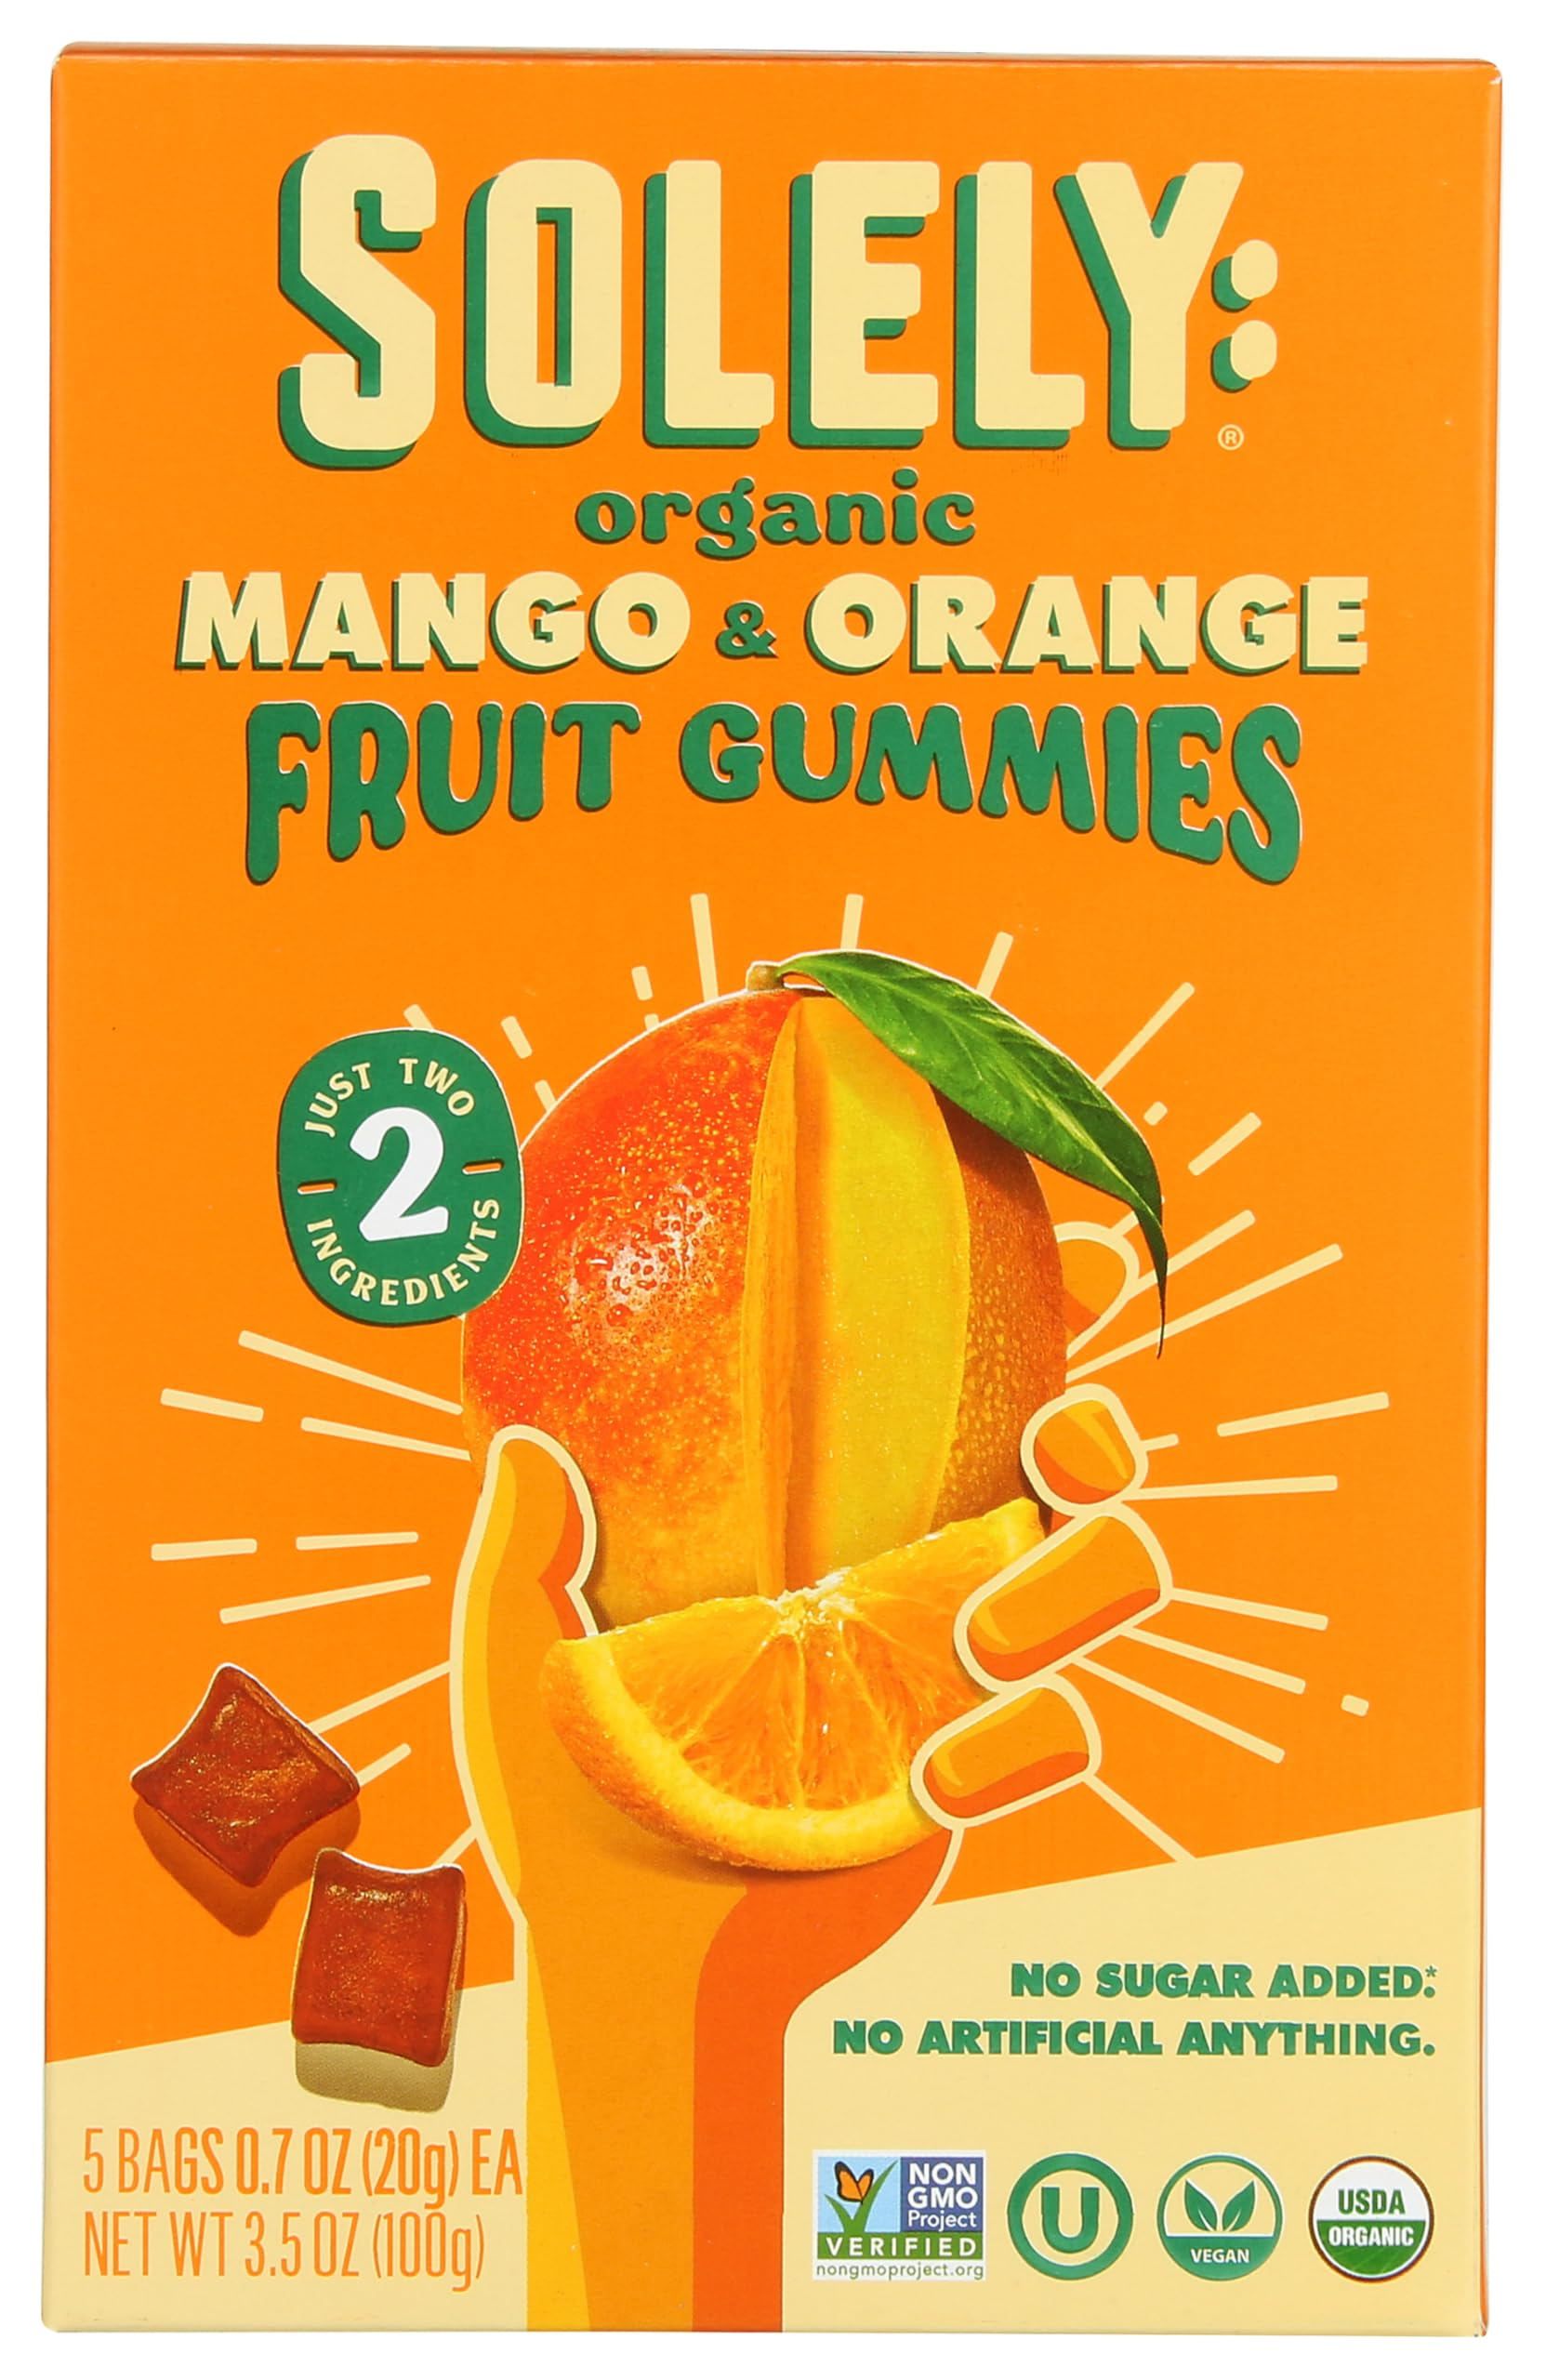

In [46]:
# Get a single image URL
test_image = images.sample(1).iloc[0] # use iloc because sample returns a Series
# test_image = images.sample(1)
display.Image(test_image, width=300, height=200)
# display.Image()

In [47]:
print(test_image)

https://m.media-amazon.com/images/I/81oi4dOgojL.jpg


## Downloading Images

In [48]:
# # functions provided by Kaggle to download images
# import re
# import os
# import pandas as pd
# import multiprocessing
# from time import time as timer
# from tqdm import tqdm
# import numpy as np
# from pathlib import Path
# from functools import partial
# import requests
# import urllib
# # download single image
# def download_image(image_link, savefolder):
#     if(isinstance(image_link, str)):
#         filename = Path(image_link).name
#         image_save_path = os.path.join(savefolder, filename)
#         if(not os.path.exists(image_save_path)):
#             try:
#                 urllib.request.urlretrieve(image_link, image_save_path)    
#             except Exception as ex:
#                 print('Warning: Not able to download - {}\n{}'.format(image_link, ex))
#         else:
#             return
#     return
# # download multiple images in parallel
# def download_images(image_links, download_folder):
#     if not os.path.exists(download_folder):
#         os.makedirs(download_folder)
#     results = []
#     download_image_partial = partial(download_image, savefolder=download_folder)
#     with multiprocessing.Pool(50) as pool:
#         for result in tqdm(pool.imap(download_image_partial, image_links), total=len(image_links)):
#             results.append(result)
#         pool.close()
#         pool.join()

# Finalize the Dataset

In [49]:
os.listdir()

['cache_224_fp16',
 'images',
 'img_cache_224',
 'out',
 'out_cpu',
 'out_fast',
 'out_gpu',
 'out_simple',
 'sample_test.csv',
 'sample_test_out.csv',
 'test.csv',
 'train.csv']

In [50]:
# images_dir_path = os.path.join(datasets_dir_path, "images")
# os.makedirs(images_dir_path, exist_ok=True)

In [51]:
# Multi-threading is somehow not working for my machine, downloading images one by one. Try the download_images function first and see if it works
# for image in images:
#     download_image(image, images_dir_path)

In [52]:
# number of images that are unable to be downloaded
len(images) - len(os.listdir("images"))

25604

In [53]:
# 
IM_DIR = Path("images")
all_paths = [p for p in IM_DIR.rglob("*")]
by_last15_fname = {}
by_last15_stem  = {}

for p in all_paths:
    fname = p.name.lower()           # e.g., abc...xyz.jpg
    stem  = p.stem.lower()           # abc...xyz
    by_last15_fname[fname[-15:]] = p
    by_last15_stem[stem[-15:]]   = p


def url_keys(url: str):
    base = Path(unquote(urlparse(url).path)).name.lower()
    return base[-15:], Path(base).stem.lower()[-15:]

def match_existing_path(url: str):
    last15_fname, last15_stem = url_keys(url)
    return (
        by_last15_fname.get(last15_fname)
        or by_last15_stem.get(last15_stem)
    )

cleaned_df["file_path_obj"] = cleaned_df["image_link"].map(match_existing_path)
cleaned_df["image_path"] = cleaned_df["file_path_obj"].map(lambda p: str(p) if p else None)

In [54]:
cleaned_df.sample(1)

,catalog_content,image_link,value,unit,sample_id,price,file_path_obj,image_path
60635,Shiloh Farms Red Split Lentils Organic -- 15 Oz\nProduct Description: Grocery,https://m.media-amazon.com/images/I/31HB9m7zhPL.jpg,15.0,Ounce,77283,5.79,images\31HB9m7zhPL.jpg,images\31HB9m7zhPL.jpg


In [55]:
# number of available images for training samples
available_count = cleaned_df["image_path"].notnull().sum()
available_count

np.int64(51852)

In [58]:
finalized_df = cleaned_df.drop(columns=["image_link", "file_path_obj"])[cleaned_df['file_path_obj'].notnull()][['sample_id', 'catalog_content', 'image_path', 'value', 'unit', 'price']]
finalized_df.reset_index(drop=True, inplace=True)
finalized_df.sample(1)

,sample_id,catalog_content,image_path,value,unit,price
10915,168863,"Crystal Light Raspberry Lemonade Drink Mix, 12-Quart 1.8-Ounce Canister (Pack Of 16)\nBullet Point 1: Each Crystal Light Canister Contains 6 2-Quart (6-2 Liter) Packets\nBullet Point 2: Contains No Caffeine and is Low in Sodium\nBullet Point 3: Kosher Product and Gluten Free\nBullet Point 4: Each Crystal Light 8 ounce (237 ml) Serving Contains 5 Calories\nProduct Description: Crystal Light turns the water you need into the water you will love. It transforms ordinary water with fabulous fruit flavors and tantalizing teas. Each sip is the perfect way to refresh, renew and satisfy your thirst for something different.",images\81nZ-AqgdjL.jpg,16.0,count,5.53


In [ ]:
# Take care of missing values in 'value' and 'unit' columns
# ===== Minimal, no-frills cleaning (run once before training) =====
df = finalized_df.copy()

# price: numeric, drop non-finite, clamp to >= 0 for log1p
df["price"] = pd.to_numeric(df["price"], errors="coerce")
df = df[np.isfinite(df["price"])]
df["price"] = df["price"].clip(lower=0)

# value: numeric; NaNs will be imputed with TRAIN median *after* the split
if "value" in df.columns:
    df["value"] = pd.to_numeric(df["value"], errors="coerce")

# unit: replace None/NaN with "<UNK>" so categoricals are safe
if "unit" in df.columns:
    df["unit"] = df["unit"].astype("string").fillna("<UNK>")

# ---- split (same as before) ----
def split_3way(d, train_frac=0.70, val_frac=0.15, seed=42):
    d_ = d.sample(frac=1.0, random_state=seed).reset_index(drop=True)
    n=len(d_); n_tr=int(n*train_frac); n_va=int(n*val_frac)
    return d_.iloc[:n_tr].copy(), d_.iloc[n_tr:n_tr+n_va].copy(), d_.iloc[n_tr+n_va:].copy()

df_tr, df_va, df_te = split_3way(df, 0.70, 0.15, seed=42)

# value median from TRAIN only → apply to all splits
if "value" in df_tr.columns:
    med = df_tr["value"].median(skipna=True)
    df_tr["value"] = df_tr["value"].fillna(med)
    df_va["value"] = df_va["value"].fillna(med)
    df_te["value"] = df_te["value"].fillna(med)

print(
    "NaN counts after clean:",
    {"price": [df_tr["price"].isna().sum(), df_va["price"].isna().sum(), df_te["price"].isna().sum()],
     "value": ([df_tr["value"].isna().sum(), df_va["value"].isna().sum(), df_te["value"].isna().sum()] if "value" in df.columns else "n/a"),
     "unit":  ([df_tr["unit"].isna().sum(),  df_va["unit"].isna().sum(),  df_te["unit"].isna().sum()]  if "unit"  in df.columns else "n/a")}
)


NaN counts after clean: {'price': [np.int64(0), np.int64(0), np.int64(0)], 'value': [np.int64(0), np.int64(0), np.int64(0)], 'unit': [np.int64(0), np.int64(0), np.int64(0)]}


In [60]:
# ======= RESNET-18 — WINDOWS-SAFE, NO-CACHE, 1 EPOCH (channels_last FIX) =======
# Needs: finalized_df with ['image_path','price']

import os, time, random, numpy as np, pandas as pd, contextlib
import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from torchvision import transforms
from torchvision.models import resnet18, ResNet18_Weights
from PIL import UnidentifiedImageError

# AMP import (version-safe)
try:
    from torch.cuda.amp import GradScaler, autocast   # legacy API
    def autocast_ctx(device): 
        return autocast() if device=="cuda" else contextlib.nullcontext()
except Exception:
    from torch.amp import GradScaler, autocast         # new API
    def autocast_ctx(device):
        return autocast(device_type="cuda", dtype=torch.float16) if device=="cuda" else contextlib.nullcontext()

# ---------------- CONFIG ----------------
IMAGES_ROOT   = ""   # set if paths are relative
IMG_SIZE      = 224
BATCH_SIZE    = 192
NUM_WORKERS   = 0
EPOCHS        = 1
LR            = 1e-3
WEIGHT_DECAY  = 5e-4
USE_LOG_PRICE = True
SEED          = 42

# ---------------- SETUP ----------------
torch.manual_seed(SEED); random.seed(SEED); np.random.seed(SEED)
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.backends.cudnn.benchmark = True
with contextlib.suppress(Exception): torch.backends.cuda.matmul.allow_tf32 = True
with contextlib.suppress(Exception): torch.backends.cudnn.allow_tf32 = True
with contextlib.suppress(Exception): torch.set_float32_matmul_precision("high")
print("Device:", device)

assert {"image_path","price"}.issubset(finalized_df.columns)

# ---------------- TRANSFORMS ----------------
IMAGENET_MEAN=(0.485,0.456,0.406); IMAGENET_STD=(0.229,0.224,0.225)
try:
    tf = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE), antialias=True),
        transforms.ConvertImageDtype(torch.float32),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ])
except TypeError:
    tf = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ConvertImageDtype(torch.float32),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ])

# ---------------- DATASET ----------------
class PriceDataset(Dataset):
    def __init__(self, df, root="", use_log=True):
        self.df = df.reset_index(drop=True).copy()
        self.use_log = use_log
        if root:
            root = os.path.abspath(root)
            self.paths = [os.path.normpath(os.path.join(root, p)) for p in self.df["image_path"]]
        else:
            self.paths = [os.path.normpath(p) for p in self.df["image_path"]]

    def __len__(self): return len(self.paths)

    def __getitem__(self, i):
        price = float(self.df.iloc[i]["price"])
        path  = self.paths[i]
        try:
            x = read_image(path)                      # 3D tensor: CxHxW
            if x.size(0)==1: x = x.expand(3, *x.shape[1:])
            x = tf(x)                                 # still 3D here
        except (FileNotFoundError, UnidentifiedImageError, RuntimeError):
            x = torch.zeros(3, IMG_SIZE, IMG_SIZE, dtype=torch.float32)
        y = torch.tensor([price], dtype=torch.float32)
        if USE_LOG_PRICE: y = torch.log1p(y)
        return x, y, torch.tensor([price], dtype=torch.float32)

# ---------------- SPLIT & LOADERS ----------------
def split_3way(df, train_frac=0.70, val_frac=0.15, seed=42):
    df_ = df.sample(frac=1.0, random_state=seed).reset_index(drop=True)
    n=len(df_); n_tr=int(n*train_frac); n_va=int(n*val_frac)
    return df_.iloc[:n_tr].copy(), df_.iloc[n_tr:n_tr+n_va].copy(), df_.iloc[n_tr+n_va:].copy()

df_tr, df_va, df_te = split_3way(finalized_df, 0.70, 0.15, SEED)
print(f"Split sizes -> train {len(df_tr)} | val {len(df_va)} | test {len(df_te)}")

ds_tr = PriceDataset(df_tr, IMAGES_ROOT, USE_LOG_PRICE)
ds_va = PriceDataset(df_va, IMAGES_ROOT, USE_LOG_PRICE)

dl_tr = DataLoader(ds_tr, batch_size=BATCH_SIZE, shuffle=True,
                   num_workers=NUM_WORKERS, pin_memory=True)
dl_va = DataLoader(ds_va, batch_size=BATCH_SIZE, shuffle=False,
                   num_workers=NUM_WORKERS, pin_memory=True)

# ---------------- MODEL ----------------
m = resnet18(weights=ResNet18_Weights.DEFAULT).to(device)
m.fc = nn.Linear(m.fc.in_features, 1).to(device)
if device=="cuda":
    m = m.to(memory_format=torch.channels_last)      # model in channels_last is fine

opt = torch.optim.AdamW(m.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
loss_fn = nn.HuberLoss(delta=1.0) if USE_LOG_PRICE else nn.MSELoss()
scaler  = GradScaler(enabled=(device=="cuda"))

@torch.no_grad()
def smape(pred,true,eps=1e-8):
    num=2.0*torch.abs(pred-true); den=torch.abs(pred)+torch.abs(true)+eps
    return torch.mean(num/den).item()*100.0
@torch.no_grad()
def mae(pred,true): return torch.mean(torch.abs(pred-true)).item()

# ---------------- SMOKE TEST (3 batches) ----------------
print("Smoke test (3 batches)…")
m.train(); seen=0; t0=time.time()
for bi, (xb, yb, _) in enumerate(dl_tr, 1):
    # NOW xb is 4D (N,C,H,W) → safe to set channels_last
    xb = xb.to(device, non_blocking=True)
    if device=="cuda":
        xb = xb.contiguous(memory_format=torch.channels_last)
    yb = yb.to(device, non_blocking=True)

    t_m0 = time.time()
    with autocast_ctx(device):
        out = m(xb); loss = loss_fn(out, yb)
    opt.zero_grad(set_to_none=True)
    scaler.scale(loss).backward(); scaler.step(opt); scaler.update()
    t_model = (time.time()-t_m0)*1000
    seen += xb.size(0)
    print(f"batch {bi} | model {t_model:.1f} ms | cum {seen} imgs")
    if bi >= 3: break
print(f"Smoke test throughput ≈ {seen/(time.time()-t0):.1f} imgs/sec")

# ---------------- TRAIN (1 epoch) ----------------
t0 = time.time()
m.train(); seen=0; run_loss=0.0
for xb, yb, _ in dl_tr:
    xb = xb.to(device, non_blocking=True)
    if device=="cuda":
        xb = xb.contiguous(memory_format=torch.channels_last)  # set after batching
    yb = yb.to(device, non_blocking=True)

    with autocast_ctx(device):
        out = m(xb); loss = loss_fn(out, yb)
    opt.zero_grad(set_to_none=True)
    scaler.scale(loss).backward(); scaler.step(opt); scaler.update()
    run_loss += loss.item()*xb.size(0); seen += xb.size(0)
tr_loss = run_loss / max(1, seen)

# ---------------- VALIDATE ----------------
m.eval(); preds=[]; truths=[]
with torch.no_grad():
    for xb, _yt, y_lin in dl_va:
        xb = xb.to(device, non_blocking=True)
        if device=="cuda":
            xb = xb.contiguous(memory_format=torch.channels_last)
        with autocast_ctx(device):
            out = m(xb).squeeze(1).detach().cpu()
        preds.append(torch.expm1(out) if USE_LOG_PRICE else out)
        truths.append(y_lin.squeeze(1))
pred = torch.cat(preds); true = torch.cat(truths)

print(f"Epoch 01 | train_loss={tr_loss:.4f} | val_SMAPE={smape(pred,true):.2f}% | val_MAE={mae(pred,true):.4f} | {time.time()-t0:.1f}s")


Device: cuda
Split sizes -> train 36296 | val 7777 | test 7779
Smoke test (3 batches)…


C:\Users\alvin\AppData\Local\Temp\ipykernel_5128\3092166864.py:110: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler  = GradScaler(enabled=(device=="cuda"))
C:\Users\alvin\AppData\Local\Temp\ipykernel_5128\3092166864.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return autocast() if device=="cuda" else contextlib.nullcontext()


batch 1 | model 1517.6 ms | cum 192 imgs
batch 2 | model 543.2 ms | cum 384 imgs
batch 3 | model 565.9 ms | cum 576 imgs
Smoke test throughput ≈ 52.8 imgs/sec
Epoch 01 | train_loss=0.3398 | val_SMAPE=67.04% | val_MAE=15.1581 | 728.5s


In [79]:
# ================= MULTIMODAL REGRESSION (IMAGE + value/unit + optional TEXT) =================
# What this does:
# - Cleans your DataFrame (price/value/unit) with minimal rules
# - Splits into train/val/test using TRAIN-only stats (impute + scale)
# - Uses ResNet-18 for images, small tower for value/unit, optional TF-IDF(+SVD) tower for catalog_content
# - Trains 1 epoch (AMP, channels_last, workers=0)

import os, time, random, contextlib, numpy as np, pandas as pd
import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from torchvision import transforms
from torchvision.models import resnet18, ResNet18_Weights
from torch.amp import autocast, GradScaler
from PIL import UnidentifiedImageError

# ---------------- Config ----------------
IMAGES_ROOT   = ""      # set folder if image_path is relative
IMG_SIZE      = 224
BATCH_SIZE    = 192
NUM_WORKERS   = 0       # Windows-safe; try 2 later if stable
EPOCHS        = 1
LR            = 1e-3
WEIGHT_DECAY  = 5e-4
USE_LOG_PRICE = True
SEED          = 42

USE_TEXT      = True    # set False to ignore catalog_content even if present
MAX_TFIDF     = 20000   # cap vocabulary
SVD_DIM       = 128     # dense text dim after SVD (compact & fast)

# ---------------- Setup ----------------
torch.manual_seed(SEED); random.seed(SEED); np.random.seed(SEED)
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.backends.cudnn.benchmark = True
with contextlib.suppress(Exception): torch.backends.cuda.matmul.allow_tf32 = True
with contextlib.suppress(Exception): torch.backends.cudnn.allow_tf32 = True
with contextlib.suppress(Exception): torch.set_float32_matmul_precision("high")
print("Device:", device, "| torch:", torch.__version__)

assert {"image_path","price"}.issubset(finalized_df.columns), "Need columns: image_path, price"

# ---------------- Minimal cleaning ----------------
df = finalized_df.copy()

# price: numeric, finite, clamp >=0 (for log1p)
df["price"] = pd.to_numeric(df["price"], errors="coerce")
df = df[np.isfinite(df["price"])]
df["price"] = df["price"].clip(lower=0)

# value: numeric (leave NaN for now; we'll impute with TRAIN median after split)
if "value" in df.columns:
    df["value"] = pd.to_numeric(df["value"], errors="coerce")

# unit: map None/NaN to "<UNK>"
if "unit" in df.columns:
    df["unit"] = df["unit"].astype("string").fillna("<UNK>")

# text: keep as string; fillna ""
HAS_TEXT = USE_TEXT and ("catalog_content" in df.columns)
if HAS_TEXT:
    df["catalog_content"] = df["catalog_content"].astype("string").fillna("")

# ---------------- Split ----------------
def split_3way(d, train_frac=0.70, val_frac=0.15, seed=42):
    d_ = d.sample(frac=1.0, random_state=seed).reset_index(drop=True)
    n=len(d_); n_tr=int(n*train_frac); n_va=int(n*val_frac)
    return d_.iloc[:n_tr].copy(), d_.iloc[n_tr:n_tr+n_va].copy(), d_.iloc[n_tr+n_va:].copy()

df_tr, df_va, df_te = split_3way(df, 0.70, 0.15, seed=SEED)
print(f"Split sizes -> train {len(df_tr)} | val {len(df_va)} | test {len(df_te)}")

# ---------------- TRAIN-only stats: value impute/scale, unit vocab, text vectorizer -------------
num_cols = [c for c in ["value"] if c in df_tr.columns]
cat_cols = [c for c in ["unit"] if c in df_tr.columns]

# value impute with TRAIN median
impute_vals = {}
for c in num_cols:
    med = df_tr[c].median(skipna=True)
    impute_vals[c] = med
    df_tr[c] = df_tr[c].fillna(med)
    df_va[c] = df_va[c].fillna(med)
    df_te[c] = df_te[c].fillna(med)

# TRAIN-only z-scale for value
scale_stats = {}
eps = 1e-6
for c in num_cols:
    mu = df_tr[c].mean()
    sd = df_tr[c].std(ddof=0)
    if sd <= 0 or not np.isfinite(sd): sd = eps
    scale_stats[c] = (mu, sd)
    df_tr[c] = (df_tr[c] - mu) / sd
    df_va[c] = (df_va[c] - mu) / sd
    df_te[c] = (df_te[c] - mu) / sd

# unit vocab (TRAIN only)
cat_maps = {}
cat_card = {}
for c in cat_cols:
    cats = pd.Categorical(df_tr[c].astype(str))
    vocab = ["<UNK>"] + list(cats.categories)
    cat_maps[c] = {tok:i for i,tok in enumerate(vocab)}
    cat_card[c] = len(vocab)

# text → TF-IDF(+SVD) on TRAIN only (optional)
text_train = text_val = text_test = None
TEXT_DIM = 0
if HAS_TEXT:
    try:
        from sklearn.feature_extraction.text import TfidfVectorizer
        from sklearn.decomposition import TruncatedSVD
        vec = TfidfVectorizer(max_features=MAX_TFIDF, ngram_range=(1,2), min_df=2)
        svd = TruncatedSVD(n_components=SVD_DIM, random_state=SEED)
        Xtr = vec.fit_transform(df_tr["catalog_content"])
        Xva = vec.transform(df_va["catalog_content"])
        Xte = vec.transform(df_te["catalog_content"])
        Xtr = svd.fit_transform(Xtr).astype("float32")
        Xva = svd.transform(Xva).astype("float32")
        Xte = svd.transform(Xte).astype("float32")
        text_train, text_val, text_test = Xtr, Xva, Xte
        TEXT_DIM = SVD_DIM
        print(f"Text branch: TF-IDF {MAX_TFIDF} → SVD {SVD_DIM} (dense)")
    except Exception as e:
        print("Text branch disabled (sklearn not available or failed):", e)
        HAS_TEXT = False
        TEXT_DIM = 0

# ---------------- Transforms ----------------
IMAGENET_MEAN=(0.485,0.456,0.406); IMAGENET_STD=(0.229,0.224,0.225)
try:
    tf = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE), antialias=True),
        transforms.ConvertImageDtype(torch.float32),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ])
except TypeError:
    tf = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ConvertImageDtype(torch.float32),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ])

# ---------------- Dataset ----------------
class MultiModalDataset(Dataset):
    def __init__(self, df, root="", num_cols=None, cat_cols=None, cat_maps=None,
                 text_mat=None, use_log=True):
        self.df = df.reset_index(drop=True).copy()
        self.use_log = use_log
        self.num_cols = num_cols or []
        self.cat_cols = cat_cols or []
        self.cat_maps = cat_maps or {}
        self.text_mat = text_mat  # dense np.array or None
        if root:
            root = os.path.abspath(root)
            self.paths = [os.path.normpath(os.path.join(root, p)) for p in self.df["image_path"]]
        else:
            self.paths = [os.path.normpath(p) for p in self.df["image_path"]]

    def __len__(self): return len(self.paths)

    def _tabular(self, idx):
        # numeric (already scaled)
        if self.num_cols:
            xnum = torch.tensor(self.df.loc[idx, self.num_cols].values.astype(float), dtype=torch.float32)
        else:
            xnum = torch.zeros(0, dtype=torch.float32)
        # categorical -> idx (UNK=0)
        xcats = []
        for c in self.cat_cols:
            tok = str(self.df.loc[idx, c])
            xcats.append(self.cat_maps[c].get(tok, 0))
        xcats = torch.tensor(xcats, dtype=torch.long) if xcats else torch.zeros(0, dtype=torch.long)
        # text dense vector if present
        if self.text_mat is not None:
            xtxt = torch.from_numpy(self.text_mat[idx])
        else:
            xtxt = torch.zeros(0, dtype=torch.float32)
        return xnum, xcats, xtxt

    def __getitem__(self, i):
        price = float(self.df.iloc[i]["price"])
        # image
        path = self.paths[i]
        try:
            ximg = read_image(path)
            if ximg.size(0)==1: ximg = ximg.expand(3, *ximg.shape[1:])
            ximg = tf(ximg)
        except (FileNotFoundError, UnidentifiedImageError, RuntimeError):
            ximg = torch.zeros(3, IMG_SIZE, IMG_SIZE, dtype=torch.float32)
        # tabular/text
        xnum, xcats, xtxt = self._tabular(i)
        # target
        y = torch.tensor([price], dtype=torch.float32)
        if USE_LOG_PRICE: y = torch.log1p(y)
        return ximg, xnum, xcats, xtxt, y, torch.tensor([price], dtype=torch.float32)

# dataset instances
ds_tr = MultiModalDataset(df_tr, IMAGES_ROOT, num_cols, cat_cols, cat_maps, text_train, USE_LOG_PRICE)
ds_va = MultiModalDataset(df_va, IMAGES_ROOT, num_cols, cat_cols, cat_maps, text_val,   USE_LOG_PRICE)

dl_tr = DataLoader(ds_tr, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=True)
dl_va = DataLoader(ds_va, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

# ---------------- Model ----------------
class ImageTower(nn.Module):
    def __init__(self, out_dim=256):
        super().__init__()
        base = resnet18(weights=ResNet18_Weights.DEFAULT)
        self.features = nn.Sequential(*list(base.children())[:-1])  # [N,512,1,1]
        self.head = nn.Linear(512, out_dim)
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.head(x)
        return x

class TabularTower(nn.Module):
    def __init__(self, num_dim, cat_cards, emb_dim=16, hidden=128):
        super().__init__()
        self.num_dim = num_dim
        self.embs = nn.ModuleList([nn.Embedding(card, emb_dim) for card in cat_cards])
        in_dim = num_dim + emb_dim*len(cat_cards)
        self.mlp = nn.Sequential(
            nn.Linear(in_dim if in_dim>0 else 1, hidden),
            nn.ReLU(inplace=True),
            nn.Linear(hidden, hidden//2),
            nn.ReLU(inplace=True),
        )
    def forward(self, xnum, xcats):
        outs = []
        if self.num_dim>0:
            outs.append(xnum)
        for i, emb in enumerate(self.embs):
            outs.append(emb(xcats[:, i]))
        z = torch.cat(outs, dim=1) if outs else torch.zeros(xnum.size(0),1,device=xnum.device)
        return self.mlp(z)

class TextTower(nn.Module):
    def __init__(self, in_dim, out_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim if in_dim>0 else 1, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, out_dim),
            nn.ReLU(inplace=True),
        )
    def forward(self, xtxt):
        if xtxt.numel()==0:
            return self.net(torch.zeros(xtxt.shape[0],1,device=xtxt.device))
        return self.net(xtxt)

class MultiModalRegressor(nn.Module):
    def __init__(self, img_out=256, num_dim=0, cat_cards=[], text_dim=0):
        super().__init__()
        self.img = ImageTower(out_dim=img_out)
        self.tab = TabularTower(num_dim, cat_cards, emb_dim=16, hidden=128)
        self.txt = TextTower(text_dim, out_dim=128) if text_dim>0 else None
        fuse_in = img_out + 64 + (128 if text_dim>0 else 0)  # 64 = hidden//2 from TabularTower
        self.head = nn.Sequential(
            nn.Linear(fuse_in, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 1),
        )
    def forward(self, ximg, xnum, xcats, xtxt):
        zi = self.img(ximg)
        zt = self.tab(xnum, xcats)
        if self.txt is not None:
            zx = self.txt(xtxt)
            z = torch.cat([zi, zt, zx], dim=1)
        else:
            z = torch.cat([zi, zt], dim=1)
        y = self.head(z)
        return y

num_dim  = len(num_cols)
cat_cards= [cat_card[c] for c in cat_cols]
model = MultiModalRegressor(img_out=256, num_dim=num_dim, cat_cards=cat_cards, text_dim=(TEXT_DIM if HAS_TEXT else 0)).to(device)
if device=="cuda": model = model.to(memory_format=torch.channels_last)

opt = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
loss_fn = nn.HuberLoss(delta=1.0) if USE_LOG_PRICE else nn.MSELoss()
scaler  = GradScaler("cuda" if device=="cuda" else "cpu")

@torch.no_grad()
def smape(pred,true,eps=1e-8):
    num=2.0*torch.abs(pred-true); den=torch.abs(pred)+torch.abs(true)+eps
    return torch.mean(num/den).item()*100.0
@torch.no_grad()
def mae(pred,true): return torch.mean(torch.abs(pred-true)).item()

def to_device(x, dtype=None):
    if isinstance(x, torch.Tensor):
        x = x.to(device, non_blocking=True)
        if dtype is not None: x = x.to(dtype)
        return x
    return x

# ---------------- Train 1 epoch ----------------
print("Training 1 epoch (multimodal)…")
t0=time.time()
model.train(); run_loss=0.0; seen=0
for ximg, xnum, xcats, xtxt, y, _ylin in dl_tr:
    ximg = to_device(ximg); 
    if device=="cuda": ximg = ximg.contiguous(memory_format=torch.channels_last)
    xnum = to_device(xnum); xcats = to_device(xcats); xtxt = to_device(xtxt)
    y    = to_device(y)

    opt.zero_grad(set_to_none=True)
    with autocast(device_type="cuda", dtype=torch.float16, enabled=(device=="cuda")):
        out = model(ximg, xnum, xcats, xtxt)
        loss= loss_fn(out, y)
    scaler.scale(loss).backward(); scaler.step(opt); scaler.update()
    run_loss += loss.item()*ximg.size(0); seen += ximg.size(0)
tr_loss = run_loss / max(1, seen)

# ---------------- Validate ----------------
model.eval(); preds=[]; truths=[]
with torch.no_grad():
    for ximg, xnum, xcats, xtxt, _y, y_lin in dl_va:
        ximg = to_device(ximg); 
        if device=="cuda": ximg = ximg.contiguous(memory_format=torch.channels_last)
        xnum = to_device(xnum); xcats = to_device(xcats); xtxt = to_device(xtxt)
        with autocast(device_type="cuda", dtype=torch.float16, enabled=(device=="cuda")):
            out = model(ximg, xnum, xcats, xtxt).squeeze(1).detach().cpu()
        preds.append(torch.expm1(out) if USE_LOG_PRICE else out)
        truths.append(y_lin.squeeze(1))
pred = torch.cat(preds); true = torch.cat(truths)

print(f"Epoch 01 (MM) | train_loss={tr_loss:.4f} | val_SMAPE={smape(pred,true):.2f}% | val_MAE={mae(pred,true):.4f} | {time.time()-t0:.1f}s")


Device: cuda | torch: 2.5.1
Split sizes -> train 36296 | val 7777 | test 7779
Text branch: TF-IDF 20000 → SVD 128 (dense)
Training 1 epoch (multimodal)…
Epoch 01 (MM) | train_loss=0.3261 | val_SMAPE=60.13% | val_MAE=13.9779 | 1202.8s
